# Investigating the effects of velocity on the shape of an orbit

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import *

In [2]:
# Set object parameters
C = 0                      # drag coefficient -- zero out to cancel drag
x_area = 0.1                    # m^2 -- cross-sectional area
mass = 100                      # kg 
h0   = 100_000               # m   –- launch altitude

# Create dictionary entries for the planets that will be compared
PLANETS = {
    "Earth": {
        "rho_0": 1.225, # kg/m^3 -- air density at sea level
        "mu":  3.986004418e14, # gravitational parameter G*M
        "R": 6_371_000, # m -- planet radius
        "H": 8400 # scale height for atm. density calculation
    },
    "Mars": {
        "mu": 4.282837e13,
        "R":  3_389_500,
        "rho_0": 0.020,
        "H": 11_100
    },
    "Kerbin": {             # 1:10 scale Earth analog from video game Kerbal Space Program
        "mu": 3.5316e12,        
        "R":   600_000,
        "rho_0": 1.225,
        "H": 5000
    }
}

In [ ]:
def curvature_radius(v_vec, a_vec):
    """
    Calculates radius of curvature in 2D using
    velocity and acceleration vectors
    R = |v|^3 / |v x a|
    """
    # Pull components from vectors
    v_r, v_t = v_vec
    ax, ay = a_vec

    # Calculate instantaneous speed
    speed = np.linalg.norm(v_vec)

    # 2D magnitude of v x a = (v_r*ay - v_t*ax)
    cross = abs(v_r*ay - v_t*ax)

    # Return curvature unless cross product = 0 
    return speed**3 / cross if cross !=0 else np.inf

def accel(state, planet):
    """
    Takes in the position and velocity
    and computes acceleration components
    that include gravity and drag
    """
    
    # Create state consisting of position and velocity components
    x,y,v_r,v_t = state

    # Get variables of planet being considered
    mu = planet["mu"]
    R = planet["R"]
    rho_0 = planet["rho_0"]
    H_scale = planet["H"]

    # Create vector arrays for position and velocity
    r_vec = np.array([x,y])
    v_vec = np.array([v_r,v_t])

    # Get magnitudes for altitude and speed
    r = np.linalg.norm(r_vec)
    speed = np.linalg.norm(v_vec)

    # Compute gravity vector
    g_vec = (-mu/r**3)*r_vec

    # Compute local atmospheric density (! needs to be updated to use piecewise regimes !)
    h = r - R
    rho_local = rho_0*np.exp(-h / H_scale) if h>= 0 else rho_0 

    # Compute drag vector as opposite of velocity vector 
    drag_vec = ( 
        -0.5 * rho_local * C * x_area/mass * speed * v_vec 
        if speed>0 else np.zeros(2)
    )

    # Create and return acceleration vector from drag and gravity 
    a_vec = g_vec + drag_vec 
    return np.array([v_r, v_t, a_vec[0], a_vec[1]])

def rk4_step(state, dt, planet):
    """
    Uses explicit RK4 integration to iterate
    over timesteps
    """
    
    k1 = accel(state, planet)
    k2 = accel(state + 0.5*dt*k1, planet)
    k3 = accel(state + 0.5*dt*k2, planet)
    k4 = accel(state + dt*k3, planet)

    return state+dt/6 * (k1 + 2*k2 + 2*k3 + k4)

def run_trajectory(v_r0,  planet, *,
                    h0=100_000,
                    dt=0.1, t_max=10000, 
                    store_path=False):
    """
    Function to run the actual trajectory and return:
    -curvature at launch 
    -impact time
    -xs,ys arrays 
    """
    r0 = planet["R"] + h0
    ts, xs, ys = ([], [], []) if store_path else (None, None, None) # record actual trajectory only when necessary

    # Initial state with given horizontal velocity and altitude
    state= np.array([r0, 0.0, 0, v_r0])
    t = 0.0

    # Curvature at t=0
    a0 = accel(state, planet)[2:] # get acceleration ax and ay
    v0 = state[2:4] # get velocity
    R_launch=curvature_radius(v0, a0)

    # Progress forward until crossing surface or reaching time
    while t< t_max and np.linalg.norm(state[:2]) > planet["R"]:
        if store_path:
            ts.append(t)
            xs.append(state[0]) # radial distance
            ys.append(state[1]) # altitude
        state = rk4_step(state, dt, planet)
        t += dt

    # Record impact time if magnitude of r_vec is less than radius of planet
    impact_time = t if np.linalg.norm(state[:2]) <= planet["R"] else np.nan

    return (impact_time, R_launch, 
            np.array(ts) if store_path else None,
            np.array(xs) if store_path else None, 
            np.array(ys) if store_path else None)

def find_crit_v(planet,*,
                v_min, v_max, n_points,
                h0, dt, t_max,
                ):
    """
    Finds the critical velocity for a planet, given a velocity range
    and starting altitude. Returns the critical velocity, the tested velocities,
    and their radii of curvature 
    """
    # Starting altitude
    r0 = planet["R"] + h0

    # Create array of velocity values to check 
    v_rs = np.linspace(v_min, v_max, n_points)
    
    # Create empty array to store radii of curvature
    R_vals = np.empty_like(v_rs)

    # Loop through velocities and calculate radii for each
    for i, v in enumerate(v_rs): 
        _, R_launch, _, _, _ = run_trajectory(v, planet, h0=h0, dt=dt, t_max=t_max)
        R_vals[i] = R_launch

    idx = np.argmin(abs(R_vals - r0)) # find index of minimum where radii of curvature equals starting altitude
    v_crit = v_rs[idx] # pull velocity at that index

    # Pull trajectory for that velocity
    _, _, ts, xs, ys = run_trajectory(v_crit, planet, h0=h0, dt=dt, t_max=t_max,
                                  store_path=True)

    return v_crit, v_rs, R_vals, ts, xs, ys

In [31]:
v_crit_Earth_10km, v_rs, R_vals, ts_crit, xs_crit, ys_crit = find_crit_v(PLANETS["Earth"], 
                                      v_min=7000, v_max = 9000,
                                      n_points=100, h0=100_000,
                                      dt=0.1, t_max=10_000)

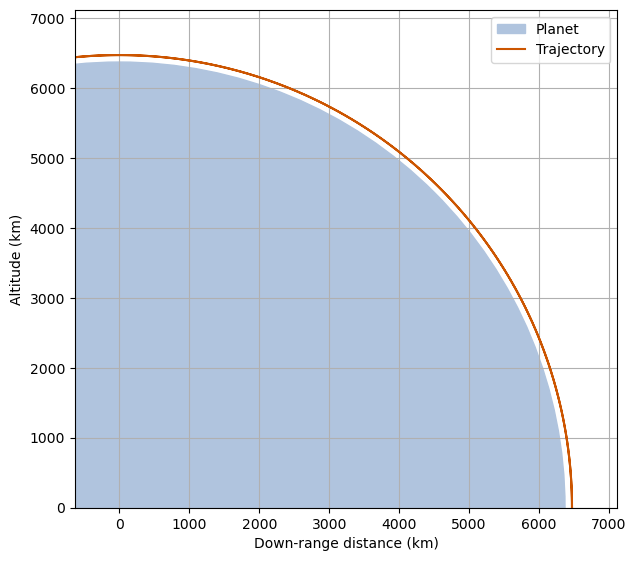

In [32]:
fig, ax = plt.subplots(figsize=(7, 7))

# Add a filled circle for the planet
planet_radius_km = PLANETS["Earth"]["R"] / 1e3
planet_surface = plt.Circle((0, 0), planet_radius_km, color="lightsteelblue", label="Planet", zorder=0)
ax.add_patch(planet_surface)

# Plot the critical velocity's trajectory
ax.plot((xs_crit) / 1e3, ys_crit / 1e3, label="Trajectory", color="#CC5500")

# Set plot limits slightly beyond the planet’s radius
ax.set_xlim(-planet_radius_km * 0.1, max(xs_crit / 1e3) * 1.1)
ax.set_ylim(0, max(ys_crit / 1e3) * 1.1)

# Appearance
ax.set_aspect("equal")
ax.set_xlabel("Down-range distance (km)")
ax.set_ylabel("Altitude (km)")
ax.legend()
ax.grid(True)
plt.show()

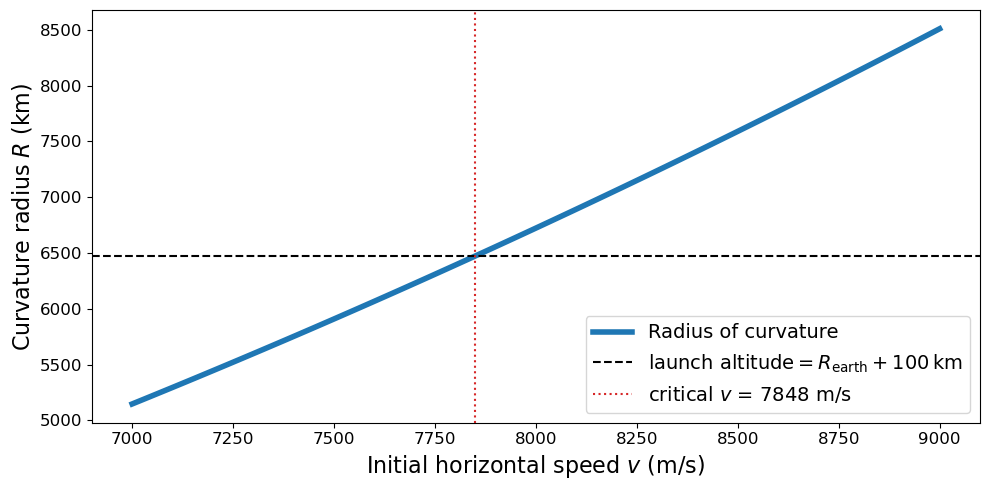

In [33]:
plt.figure(figsize=(10, 5))
plt.plot(v_rs, R_vals/1e3, label='Radius of curvature', linewidth=4)

# Earth 
r0 = PLANETS["Earth"]["R"] + h0
plt.axhline(r0/1000, color='k', linestyle='--',
            label=rf'$\mathrm{{launch \ altitude}} = R_\mathrm{{earth}}+{h0/1000:.0f}\,\mathrm{{km}}$')
plt.axvline(v_crit_Earth_10km, color='C3', linestyle=':',
            label=rf'critical $v$ = {v_crit_Earth_10km:.0f} m/s')

plt.xlabel('Initial horizontal speed $v$ (m/s)', fontsize=16)
plt.xticks(fontsize=12)
plt.ylabel('Curvature radius $R$ (km)', fontsize=16)
plt.yticks(fontsize=12)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

## Specific mechanical energy

In [34]:
def specific_energy(state, planet):
    """
    Calculates specific mechanical energy using
    velocity and position vectors 
    ε = ½|v|² - μ/|r|
    """

    x,y,v_r,v_t = state 
    r = np.hypot(x,y) # alternate method to calculate magnitude
    v = np.hypot(v_r, v_t)
    return 0.5*v**2 - planet["mu"]/r

def find_escape_v( planet, *,
                  v_min, v_max, n_points,
                  h0, dt, t_max):
    
    # Launch radius
    r0 = planet["R"] + h0

    global C
    C = 0 # set to 0 to analyze specific mechanical energy

    # Build test grid
    vs = np.linspace(v_min, v_max, n_points)
    eps0s = np.empty_like(vs)

    # Sweep 
    for i,v in enumerate(vs):
        state0 = np.array([r0, 0.0, 0.0, v])
        eps0s[i] = specific_energy(state0, planet)

    # Mask out negative epsilons
    mask = eps0s >= 0
    if not np.any(mask):
        raise RuntimeError("All epsilons are negative")

    # Pick index of smallest 
    valid_idxs = np.where(mask)[0]
    best_subidx = np.argmin(eps0s[valid_idxs])
    best_idx = valid_idxs[best_subidx]

    v_escape = vs[best_idx]

    # Pull full trajectory of escape velocity

    _, _, ts, xs, ys = run_trajectory(
        v_escape, planet, h0=h0, dt=dt, t_max=t_max, store_path=True
    )

    return v_escape, vs, eps0s, ts, xs, ys


In [36]:
earth_escape_v_10km, esc_vels, eps0s, ts_esc, xs_esc, ys_esc = find_escape_v(PLANETS["Earth"], v_min = 8000, v_max = 14000, n_points=50,
                                                                             h0=10_000, dt=0.1, t_max=10_000)

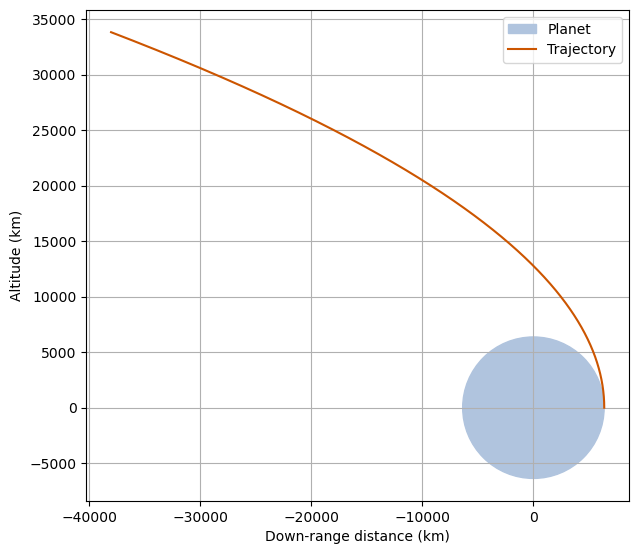

In [40]:
fig, ax = plt.subplots(figsize=(7, 7))

# Add a filled circle for the planet
planet_radius_km = PLANETS["Earth"]["R"] / 1e3
planet_surface = plt.Circle((0, 0), planet_radius_km, color="lightsteelblue", label="Planet", zorder=0)
ax.add_patch(planet_surface)

# Plot the critical velocity's trajectory
ax.plot((xs_esc) / 1e3, ys_esc / 1e3, label="Trajectory", color="#CC5500")

# Set plot limits slightly beyond the planet’s radius
#ax.set_xlim(-planet_radius_km * 0.1, max(xs_esc / 1e3) * 1.1)
#ax.set_ylim(0, max(ys_esc / 1e3) * 1.1)

# Appearance
ax.set_aspect("equal")
ax.set_xlabel("Down-range distance (km)")
ax.set_ylabel("Altitude (km)")
ax.legend()
ax.grid(True)
plt.show()